# Combining step protocols with sine waves or ramps

In previous examples we used a [myokit.Protocol](https://myokit.readthedocs.io/api_simulations/Protocol.html) to encode a voltage protocol consisting of a sequence of fixed-voltage steps.

In this part of the tutorial, we'll show how to dynamically update a model's equations to allow more complex shapes such as ramps and sine waves.

## Adding ramps to the step protocol

We'll try to copy the following protocol:

odict_keys(['time', 'voltage'])


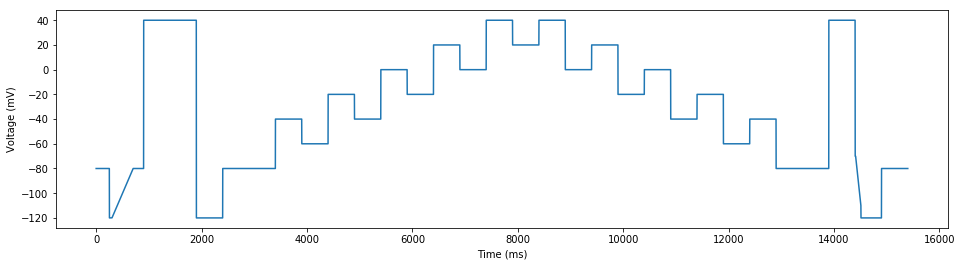

In [4]:
import matplotlib.pyplot as plt
import myokit
import numpy as np

# Load a CSV file
d1 = myokit.DataLog.load_csv('resources/protocol-staircaseramp.csv')

# Convert Python lists to NumPy arrays
d1 = d1.npview()

# Convert time to ms
d1['time'] *= 1000

# Get time just after protocol is finished
tmax = d1['time'][-1] + 0.1

# Show the contents
print(d1.keys())

# Create a plot
plt.figure(figsize=(16, 4))
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.plot(d1.time(), d1['voltage'])
plt.show()

In previous examples, we used a ramp-free version of the protocol:

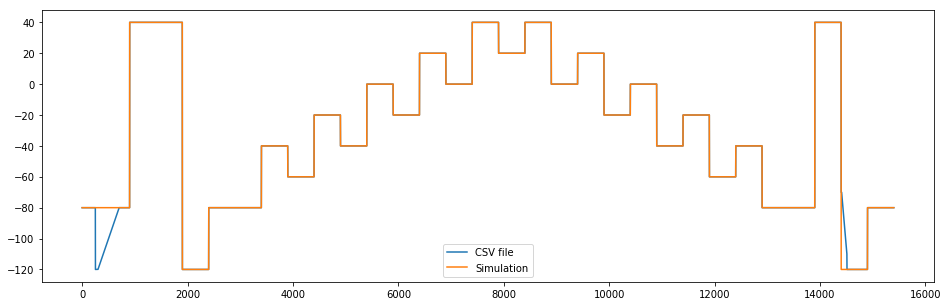

In [11]:
m = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')
p = myokit.load_protocol('resources/simplified-staircase.mmt')
s = myokit.Simulation(m, p)

d2 = s.run(tmax, log_times=d1.time())

plt.figure(figsize=(16, 5))
plt.plot(d1.time(), d1['voltage'], label='CSV file')
plt.plot(d2.time(), d2['membrane.V'], label='Simulation')
plt.legend()
plt.show()

To add in the ramps, we inspect the CSV file a bit closer and define equations for both.

### Ramp 1

$V_1(t=300) = -120$

$V_1(t=700) = -80$

$V_1 = -120 + (t - 300) * 40 / 400 = -150 + t / 10$


### Ramp 2

$V_1(t=14410) = -70$

$V_1(t=14510) = -110$

$V_2 = -70 + (t - 14410) * -40 / 100 = 5694 - 0.4 t$

We can graphically check that these equations create the lines we want them to:

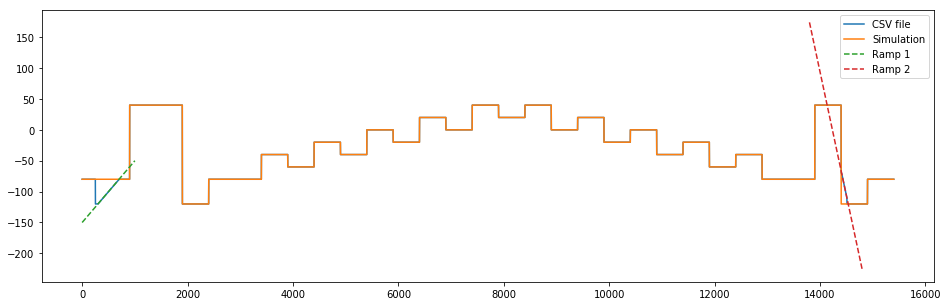

In [12]:
plt.figure(figsize=(16, 5))
plt.plot(d1.time(), d1['voltage'], label='CSV file')
plt.plot(d2.time(), d2['membrane.V'], label='Simulation')

t1 = np.linspace(0, 1000, 1000)
v1 = -150 + 0.1 * t1

t2 = np.linspace(13800, 14800, 1000)
v2 = 5694 - 0.4 * t2

plt.plot(t1, v1, '--', label='Ramp 1')
plt.plot(t2, v2, '--', label='Ramp 2')

plt.legend()
plt.show()

Now we'll add these ramps into the model, by programmatically modifying the `membrane` component:

In [13]:
print(m.get('membrane').code())

[membrane]
V = 0 [mV] bind pace label membrane_potential




We'll replace this by something of the form:

\begin{align}
vp  &= \text{step protocol} \\
v1 &= -150 + 0.1 * t \\
v2 &= 5694 - 0.4 * t \\
V  &= \begin{cases}
    v1 & \mbox{ if } 300 \leq t < 700 \\
    v2 & \mbox{ if } 14410 \leq t < 14510 \\
    vp  & \mbox{ otherwise} \\
\end{cases}
\end{align}

In [18]:
# Load the model
m = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')

# Get the membrane component
c = m.get('membrane')

# Get the voltage variable, and remove its binding to `pace`
v = c.get('V')
v.set_binding(None)

# Add a v1 variable
v1 = c.add_variable('v1')
v1.set_rhs('-150 + 0.1 * engine.time')

# Add a v2 variable
v2 = c.add_variable('v2')
v2.set_rhs('5694 - 0.4 * engine.time')

# Add a p variable
vp = c.add_variable('vp')
vp.set_rhs(0)
vp.set_binding('pace')

# Set a new right-hand side equation for V
v.set_rhs("""
    piecewise(
        (engine.time >= 300 and engine.time < 700), v1, 
        (engine.time >=14410 and engine.time < 14510), v2, 
        vp)
""")

In [19]:
print(c.code())

[membrane]
V = piecewise(engine.time >= 300 and engine.time < 700, v1, engine.time >= 14410 and engine.time < 14510, v2, vp)
    label membrane_potential
v1 = -150 + 0.1 * engine.time
v2 = 5694 - 0.4 * engine.time
vp = 0 bind pace




We now run a simulation with the updated model and compare:

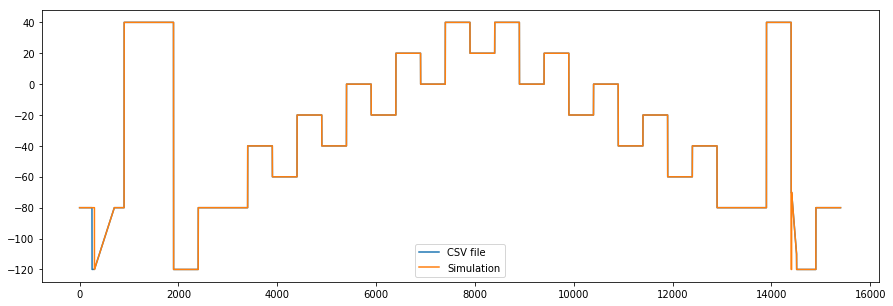

In [20]:
s = myokit.Simulation(m, p)

d2 = s.run(tmax+10, log_times=d1.time())

plt.figure(figsize=(15, 5))
plt.plot(d1.time(), d1['voltage'], label='CSV file')
plt.plot(d2.time(), d2['membrane.V'], label='Simulation')
plt.legend()
plt.show()

Just to be sure, we inspect the difference:

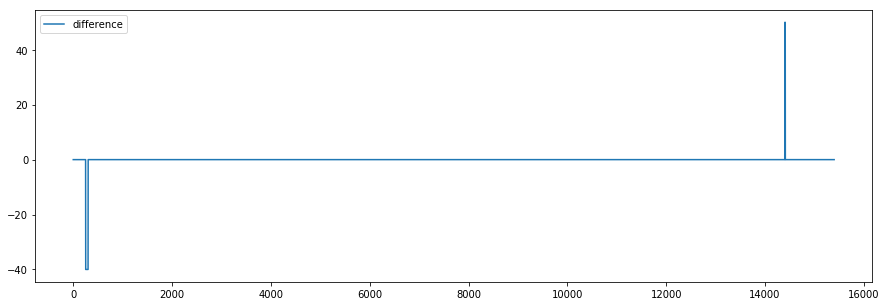

In [21]:
plt.figure(figsize=(15, 5))
plt.plot(d1.time(), d1['voltage'] - d2['membrane.V'], label='difference')
plt.legend()
plt.show()

So, we have matched the protocol in the CSV file very closely!